<a href="https://colab.research.google.com/github/trian-gles/pytorch-guitar-amp-modelling/blob/main/GuitarLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import time
from scipy.io import wavfile
from IPython.display import clear_output
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/gdrive/', force_remount=True)
    import sys

Mounted at /content/gdrive/


In [78]:
import matplotlib.pyplot as plt

In [2]:
%cd /content/gdrive/MyDrive/amp-sim-samples/

/content/gdrive/MyDrive/amp-sim-samples


### Pre emphasis filter

In [3]:
filt = torch.nn.Conv1d(1, 1, 2)
filt.bias = torch.nn.Parameter(torch.zeros(1))
filt.weight = torch.nn.Parameter(torch.tensor([[[-0.95, 1.]]]))

pre_filt = torch.nn.Sequential(
    torch.nn.ConstantPad1d((1, 0), 0),
    filt
)

### loss fns

In [194]:
def esr_loss(y, y_hat):
  return torch.sum(torch.square(y - y_hat)) / (torch.sum(torch.square(y)) + 1e-10)

def dc_loss(y, y_hat):
  return torch.square(torch.mean(y - y_hat)) / torch.mean(torch.square(y) + 1e-10)

def combined_loss(y, y_hat):
  #print(f"SHAPES OF Y_HAT : {y_hat.shape} Y : {y.shape}")
  y, y_hat = pre_filt(y), pre_filt(y_hat)
  
  return esr_loss(y, y_hat) + dc_loss(y, y_hat)

In [190]:
pred = torch.zeros(160).reshape((4, 1, 40)).float()
exp = torch.zeros(160).reshape((4, 1, 40)).float() + 0.000001
combined_loss(pred, exp)

SHAPES OF Y_HAT : torch.Size([4, 1, 40]) Y : torch.Size([4, 1, 40])


tensor(0.0440, grad_fn=<AddBackward0>)

### Training

#### Hidden state and cell

In [192]:
from torch.autograd.grad_mode import no_grad
# Taken from https://discuss.pytorch.org/t/implementing-truncated-backpropagation-through-time/15500/3
class TBPTT_CELL():
    '''
    truncated backprop runner for modules with both hidden and cell states (such as LSTM)
    '''
    def __init__(self, one_step_module, loss_module, k1, k2, no_grad_steps, optimizer):
        self.one_step_module = one_step_module
        self.loss_module = loss_module
        self.k1 = k1
        self.k2 = k2
        self.no_grad_steps = no_grad_steps
        self.retain_graph = True
        # You can also remove all the optimizer code here, and the
        # train function will just accumulate all the gradients in
        # one_step_module parameters
        self.optimizer = optimizer

    def train(self, X, y, init_states):
        hidden_state, cell_state = init_states
        
        self.one_step_module.idx = 0
        hidden_states = [(None, hidden_state)]
        cell_states = [(None, cell_state)]
        target_sequence = []
        output_sequence = []
        #print(f"Signal shape = {y.shape[-1]}")
        for j in range(y.shape[-1]):
            inp = X[:, j].unsqueeze(1).unsqueeze(1)
            target = y[:, j].unsqueeze(1).unsqueeze(1)
            #print(f"Input shape = {inp.shape}")
            if (j < self.no_grad_steps):
              with torch.no_grad():
                self.one_step_module.idx += 1

                output, new_states = self.one_step_module(inp, (hidden_state, cell_state))
                hidden_state, cell_state = new_states

                hidden_states = [(None, hidden_state)]
                cell_states = [(None, cell_state)]
            else:
              hidden_state = hidden_states[-1][1].detach()
              cell_state = cell_states[-1][1].detach()


              hidden_state.requires_grad=True
              cell_state.requires_grad=True

              output, new_states = self.one_step_module(inp, (hidden_state, cell_state))
              new_hidden, new_cell = new_states

              hidden_states.append((hidden_state, new_hidden))
              cell_states.append((cell_state, new_cell))
              target_sequence.append(target)
              output_sequence.append(output)

              while len(cell_states) > self.k2:
                  # Delete stuff that is too old
                  del hidden_states[0]
                  del cell_states[0]

              if (j+1 + no_grad_steps)%self.k1 == 0:
                  loss = self.loss_module(torch.cat(target_sequence, dim=-1), torch.cat(output_sequence, dim=-1))
                  print(f"Backwards step with loss {loss}")
                  optimizer.zero_grad()
                  # backprop last module (keep graph only if they ever overlap)
                  start = time.time()
                  loss.backward(retain_graph=self.retain_graph)
                  for i in range(self.k2-1):
                      # if we get all the way back to the "init_state", stop
                      if cell_states[-i-2][0] is None:
                          break
                      curr_grad_hidden = hidden_states[-i-1][0].grad
                      curr_grad_cell = cell_states[-i-1][0].grad

                      hidden_states[-i-2][1].backward(curr_grad_hidden, retain_graph=self.retain_graph)
                      cell_states[-i-2][1].backward(curr_grad_cell)

                  
                  target_sequence = []
                  output_sequence = []
                  optimizer.step()


no_grad_steps = 20
seq_len = 20000
k1 = 3
k2 = 3
input_size = 1
output_size = 1
batch_size = 20

lstm_blocks = 1

idx = 0

hidden_size = 96
one_step_module = MyMod(hidden_size)
loss_module = combined_loss

input_sequence = [(torch.ones(batch_size, 1, input_size), torch.zeros(batch_size, 1, output_size))] * seq_len

optimizer = torch.optim.SGD(one_step_module.parameters(), lr=1e-3)

runner = TBPTT_CELL(one_step_module, loss_module, k1, k2, no_grad_steps, optimizer)

#runner.train(input_sequence, (torch.zeros(1, batch_size, hidden_size), torch.zeros(1, batch_size, hidden_size)))
print("done")

done


In [65]:
def train(one_step_module, loss_module, k1, k2, no_grad_steps, optimizer, train_loader, initial_states, epochs):
  runner = TBPTT_CELL(one_step_module, loss_module, k1, k2, no_grad_steps, optimizer)
  for j in range(epochs):
    print(f"EPOCH {j}")
    for i, (X, y) in enumerate(train_loader):
      print(f"TRAINING SEQUENCE {i}")
      runner.train(X, y, initial_states)

### Dataloader

In [47]:
class MyDataset(torch.utils.data.Dataset):
  '''Takes as input filenames for the raw and processed guitar signal'''
  def __init__(self, x_filename, y_filename, seq_len=22050):
        'Initialization'
        X_np = wavfile.read(x_filename)[1][:, 0]
        y_np = wavfile.read(y_filename)[1][:, 0]

        X_max = max(abs(X_np))
        y_max = max(abs(y_np))
        count = len(y_np) // seq_len
        effective_size = count * seq_len
        self.X_set = torch.tensor(X_np[:effective_size]).reshape(count, seq_len) / X_max
        self.y_set = torch.tensor(y_np[:effective_size]).reshape(count, seq_len) / y_max

  def __len__(self):
        'Denotes the total number of samples'
        return self.y_set.shape[0]
  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        X = self.X_set[index].float()
        y = self.y_set[index].float()
        return X, y

### Datasets

In [48]:
BATCHSIZE = 20

In [49]:
train_dataset = MyDataset("amp-sim-train-X.wav", "amp-sim-train-y.wav")
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCHSIZE, shuffle=True)

valid_dataset = MyDataset("amp-sim-valid-X.wav", "amp-sim-valid-y.wav")
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCHSIZE)

<ipython-input-47-e7cf6d94c59e>:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  X_np = wavfile.read(x_filename)[1][:, 0]
<ipython-input-47-e7cf6d94c59e>:6: WavFileWarning: Chunk (non-data) not understood, skipping it.
  y_np = wavfile.read(y_filename)[1][:, 0]


In [56]:
for X_train, y_train in train_loader:
  print(X_train.shape)
  print(y_train.shape)

print(X_train.min())

torch.Size([20, 22050])
torch.Size([20, 22050])
torch.Size([20, 22050])
torch.Size([20, 22050])
torch.Size([20, 22050])
torch.Size([20, 22050])
torch.Size([20, 22050])
torch.Size([20, 22050])
torch.Size([20, 22050])
torch.Size([20, 22050])
torch.Size([20, 22050])
torch.Size([20, 22050])
torch.Size([20, 22050])
torch.Size([20, 22050])
torch.Size([20, 22050])
torch.Size([20, 22050])
torch.Size([20, 22050])
torch.Size([20, 22050])
torch.Size([20, 22050])
torch.Size([20, 22050])
torch.Size([20, 22050])
torch.Size([20, 22050])
torch.Size([20, 22050])
torch.Size([20, 22050])
torch.Size([20, 22050])
torch.Size([20, 22050])
torch.Size([20, 22050])
torch.Size([20, 22050])
torch.Size([20, 22050])
torch.Size([20, 22050])
torch.Size([20, 22050])
torch.Size([20, 22050])
torch.Size([20, 22050])
torch.Size([20, 22050])
torch.Size([20, 22050])
torch.Size([20, 22050])
tensor(-0.8989)


### Model

In [53]:
class MyMod(nn.Module):
    def __init__(self, hidden_size=5):
        super(MyMod, self).__init__()
        self.lstm = torch.nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.lin = torch.nn.Linear(hidden_size, output_size)
        self.idx = 0
          
    def forward(self, inp, state):
        out, states = self.lstm(inp, state)
        
        out = self.lin(out)
        
        hidden_state, cell_state = states

        if out.requires_grad:
          def get_pr(idx_val):
              def pr(*args):
                pass
                  #print("doing backward {}".format(idx_val))
              return pr
          hidden_state.register_hook(get_pr(self.idx))
          #cell_state.register_hook(get_pr(idx))
          out.register_hook(get_pr(self.idx))
          #print("doing fw {}".format(self.idx))
          self.idx += 1
        out += inp # residual connection
          
        return out, states

### Here we go:

In [ ]:
no_grad_steps = 1000
k1 = 2000
k2 = 2000
input_size = 1
output_size = 1

EPOCHS = 3
lstm_blocks = 1
hidden_size = 96
one_step_module = MyMod(hidden_size)
loss_module = combined_loss
initial_states = (torch.zeros(1, BATCHSIZE, hidden_size), torch.zeros(1, BATCHSIZE, hidden_size))

optimizer = torch.optim.Adam(one_step_module.parameters())

train(one_step_module, loss_module, k1, k2, no_grad_steps, optimizer, train_loader, initial_states, EPOCHS)

EPOCH 0
TRAINING SEQUENCE 0
Backwards step with loss 1.187622308731079
Backwards step with loss 1.1622949838638306
Backwards step with loss 1.1507800817489624
Backwards step with loss 1.1640139818191528
Backwards step with loss 1.0737359523773193
Backwards step with loss 1.0438851118087769
Backwards step with loss 1.0800293684005737
Backwards step with loss 1.072708010673523
Backwards step with loss 1.066208839416504
Backwards step with loss 1.0859105587005615
TRAINING SEQUENCE 1
Backwards step with loss 1.131580114364624
Backwards step with loss 1.1223978996276855
Backwards step with loss 1.1521342992782593
Backwards step with loss 1.0880857706069946
Backwards step with loss 1.0813249349594116
Backwards step with loss 1.133497714996338
Backwards step with loss 1.1503053903579712
Backwards step with loss 1.0998337268829346
Backwards step with loss 1.070680856704712
Backwards step with loss 1.1273255348205566
TRAINING SEQUENCE 2
Backwards step with loss 1.1286370754241943
Backwards step

In [196]:
with torch.no_grad():
  for X_valid, y_valid in valid_loader:
    y_hat_valid, _ = one_step_module.forward(X_valid.unsqueeze(-1), initial_states)
    break

In [197]:
y_hat_valid.squeeze().shape

torch.Size([20, 22050])

In [134]:
y_valid.shape

torch.Size([20, 22050])

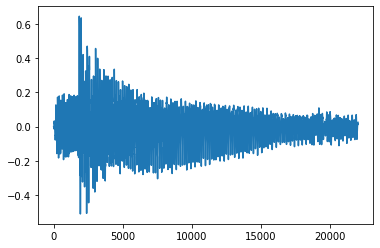

In [200]:
plt.plot(X_valid[0, :].squeeze())

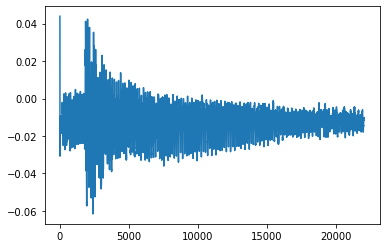

In [198]:

plt.plot(y_hat_valid[0, :].squeeze())

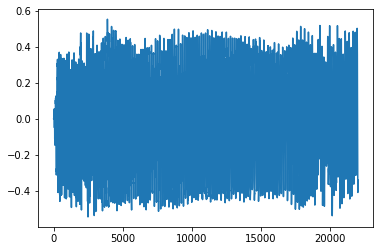

In [199]:
plt.plot(y_valid[0, :].squeeze())

In [188]:
combined_loss(y_valid.unsqueeze(1)[:, :, :2000], y_hat_valid.squeeze().unsqueeze(1)[:, :, :2000])

SHAPES OF Y_HAT : torch.Size([20, 1, 2000]) Y : torch.Size([20, 1, 2000])


tensor(1.1365, grad_fn=<AddBackward0>)

In [185]:
from IPython.display import Audio

In [206]:
Audio(data=y_valid[0, :].squeeze(), rate=44100)